# Developing and testing machine learning strategies

**The purpose of this notebook is to develop and validate models for predicting whether a Kickstarter project will be funded based on a campaign section.** 

## Table of contents
1. [Loading the data](#cell1)
2. [Constructing the design matrix](#cell2)
3. [Preparing the features](#cell3)
4. [Preparing the target variable](#cell4)
5. [Evaluating regression models](#cell5)
6. [Evaluating classifiers](#cell6)
7. [Diagnosing the classifier with learning curves](#cell7)
8. [Using nested cross-validation to optimize hyperparameters](#cell8)
9. [Top predictors of funded projects](#cell9)
10. [Testing Kickstarter pages](#cell10)

<a id="cell1"></a>
## 1. Loading the data

In [1]:
# Load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import feature_engineering
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.externals import joblib
from sklearn.model_selection import (
    train_test_split, learning_curve, StratifiedShuffleSplit, GridSearchCV,
    cross_val_score, ShuffleSplit, cross_val_predict
)

# Set figure display options
%matplotlib inline
sns.set(context='notebook', style='darkgrid')
sns.set(font_scale=1.3)

The training set for both campaign sections are stored in PostgreSQL databases. Let's begin by loading the credentials to connect to the databases.

In [2]:
# Set database credentials
db_name1 = 'section1'
db_name2 = 'section2'
usernm = 'redwan'
host = 'localhost'
port = '5432'
#pwd = ''

We can now connect to the databases, query all the data for both campaign sections, and store them locally.

In [3]:
# Prepare a connection to database for section 1
con1 = psycopg2.connect(
    database=db_name1, 
    host='localhost',
    user=usernm,
    password=pwd
)

# Prepare a connection for section 2
con2 = psycopg2.connect(
    database=db_name2, 
    host='localhost',
    user=usernm,
    password=pwd
)

# Query all data from both campaign sections
sql_query1 = 'SELECT * FROM section1;'
sql_query2 = 'SELECT * FROM section2;'
section1_df_full = pd.read_sql_query(sql_query1, con1)
section2_df_full = pd.read_sql_query(sql_query2, con2)

### Two approaches

We can either approach this problem as a classification task and attempt to predict whether a project will be funded or not. Another option is to predict what % of the goal will the project reach and therefore, approach the problem as a regression task. 

Let's start with the latter. To do so, let's define a new target variable that measures what % of the goal was reached for each project in the training set.

In [4]:
# Define a target variable for regression
section1_df_full['percent_funded'] = section1_df_full['pledged'] / \
    section1_df_full['goal']

# Display a few rows
section1_df_full.head(3)

,level_0,index,num_sents,num_words,num_all_caps,percent_all_caps,num_exclms,percent_exclms,num_apple_words,percent_apple_words,...,percent_bolded,name,category,hyperlink,currency,pledged,goal,location,funded,percent_funded
0,0,88389,15.0,223.0,0.0,0.000000,3.0,0.002317,0.0,0.000000,...,0.0,Help me start my cottage industry ... Bakesale...,Small Batch,https://www.kickstarter.com/projects/138529431...,USD,0.0,10000.0,"Cape Coral, FL",False,0.000000
1,1,190378,15.0,383.0,0.0,0.000000,4.0,0.003089,0.0,0.000000,...,0.0,The Sock Who Lost His Mate at NY Children's Th...,Musical,https://www.kickstarter.com/projects/987315242...,USD,2600.0,7000.0,"Greenwich Village, Manhattan, NY",False,0.371429
2,2,21028,15.0,259.0,17.0,0.013127,0.0,0.000000,1.0,0.000772,...,0.0,The 4 Disciples,Comic Books,https://www.kickstarter.com/projects/the4disci...,USD,165.0,2200.0,"Rahway, NJ",False,0.075000


<a id="cell2"></a>
## 2. Constructing the design matrix

The first step is to select the features that we'll utilize for prediction. For now, let's use the computed features listed below for only the "About this project" section of the campaigns.

In [5]:
# A list of features to use in the machine learning model
features = ['num_sents', 'num_words', 'num_all_caps', 'percent_all_caps',
            'num_exclms', 'percent_exclms', 'num_apple_words',
            'percent_apple_words', 'avg_words_per_sent', 'num_paragraphs',
            'avg_sents_per_paragraph', 'avg_words_per_paragraph',
            'num_images', 'num_videos', 'num_youtubes', 'num_gifs',
            'num_hyperlinks', 'num_bolded', 'percent_bolded']

# Select features
X = section1_df_full[features]

# Display the first five rows of the design matrix
X.head()

,num_sents,num_words,num_all_caps,percent_all_caps,num_exclms,percent_exclms,num_apple_words,percent_apple_words,avg_words_per_sent,num_paragraphs,avg_sents_per_paragraph,avg_words_per_paragraph,num_images,num_videos,num_youtubes,num_gifs,num_hyperlinks,num_bolded,percent_bolded
0,15.0,223.0,0.0,0.000000,3.0,0.002317,0.0,0.000000,14.866667,9.0,1.888889,24.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,15.0,383.0,0.0,0.000000,4.0,0.003089,0.0,0.000000,25.533333,5.0,3.000000,76.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,15.0,259.0,17.0,0.013127,0.0,0.000000,1.0,0.000772,17.266667,17.0,0.823529,11.470588,15.0,0.0,0.0,0.0,8.0,0.0,0.000000
3,18.0,431.0,0.0,0.000000,3.0,0.002317,1.0,0.000772,23.944444,3.0,6.000000,143.666667,0.0,0.0,0.0,0.0,2.0,0.0,0.000000
4,23.0,283.0,2.0,0.001544,15.0,0.011583,0.0,0.000000,12.304348,5.0,4.600000,56.600000,1.0,0.0,0.0,0.0,0.0,12.0,0.009266


<a id="cell3"></a>
## 3. Preparing the features

### Data wrangling

Some of the projects may contain missing values. We need to decide how to deal with these projects since models in Scikit-learn cannot interpret them.

One strategy is to first remove all projects that have no data. These projects are most likely those that failed to complete an "About this project" section and can safely be excluded.

In [6]:
# Remove all rows with no data
X_cleaned = X[~X.isnull().all(axis=1)]

For the remaining projects with missing values, we can fill them with zeros. This makes sense since missing values arise as a result of missing data or if the number of words in the section is zero. This latter result may have caused a `DivisionByZeroError` during feature engineering but we addressed it by setting those features to `NaN`.

In [7]:
# Fill remaining missing values with zero
X_cleaned = X_cleaned.fillna(0)

### Standardizing the features

Most machine learning models, besides tree-based models, only function if the features are standardized to have zero mean and unit variance, while others will converge faster. Let's go ahead and standardize the features.

In [8]:
# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_cleaned)

<a id="cell4"></a>
## 4. Preparing the target variable

Let's first select all rows of the regression target variable `percent_funded` that correspond to the rows in the cleaned design matrix.

In [9]:
# Select rows of the regression target variable corresponding to the cleaned
# design matrix
y_reg = section1_df_full.loc[X_cleaned.index, 'percent_funded'].to_frame()

### Encoding the target variable for classification

For classification tasks, the models in Scikit-learn will work only if the classification target variable `funded` is encoded numerically. To do so, let's first select all rows of `funded` that correspond to the rows in the cleaned design matrix.

In [10]:
# Select rows of the classification target variable corresponding to the 
# cleaned design matrix
y = section1_df_full.loc[X_cleaned.index, 'funded'].to_frame()

Before encoding the target variable, let's take a peek at the class distribution.

In [11]:
# Display the class distribution
y['funded'].value_counts()

False    13894
True     10633
Name: funded, dtype: int64

The classes are distributed about 3 to 7, which is slightly imbalanced. We'll keep this mind when choosing a performance metric. Finally, let's encode the target variable.

In [12]:
# Encode the class labels in the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

<a id="cell5"></a>
## 5. Evaluating regression models

We'll use an Occam's razor approach and start with models that are parametric (fast to train, less prone to overfitting), linear (since text-based data is innately linear) and explainable (since it's preferable for the creator to understand how the model made its prediction).

Let's begin by testing ordinary least squares regression using a 10-fold cross-validation strategy with a randomized 80/20 training/test set split. We'll also use the correlation of determination $R^2$ as the performance metric and take a look at its distribution across cross-validation folds.

In [13]:
# Cross-validate an OLS regression model
scores = cross_val_score(
    estimator=LinearRegression(),
    X=X_std,
    y=y_reg.values.ravel(),
    cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='r2',
    n_jobs=-1
)

# Display the average and standard deviation of the cross-validation scores
print('R^2: {} +/- {}'.format(scores.mean(), scores.std()))

R^2: -0.308878894335315 +/- 0.4594258307965158


Since $R^2$ varies wildly, this model is unstable. Let's try support vector machines with a linear kernel next with the default hyperparameters.

In [14]:
# Cross-validate an SVM regression model with a linear kernel
scores = cross_val_score(
    estimator=svm.LinearSVR(),
    X=X_std,
    y=y_reg.values.ravel(),
    cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='r2',
    n_jobs=-1
)

# Display the average and standard deviation of the cross-validation scores
print('R^2: {} +/- {}'.format(scores.mean(), scores.std()))

R^2: -0.0006531454715426044 +/- 0.0005131787368637863


Since $R^2$ is nearly zero, this means the model explains almost none of the variability of the target variable&mdash;perhaps the features are non-linear. Therefore, let's try a random forest with the default hyperparameters instead.

In [15]:
# Cross-validate a random forest model
scores = cross_val_score(
    estimator=RandomForestRegressor(),
    X=X_std,
    y=y_reg.values.ravel(),
    cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='r2',
    n_jobs=-1
)

# Display the average and standard deviation of the cross-validation scores
print('R^2: {} +/- {}'.format(scores.mean(), scores.std()))

R^2: -2.726700516075406 +/- 4.019613348055869


Even with a non-linear model, $R^2$ not only varies wildly but reaches values below $-1$. This is a strong hint that the model cannot predict the regression target variable. We likely don't have enough information in the feature space to predict something as nuanced as the % of the goal that will be reached by the project. 

Let's switch to a simpler target variable and focus on classification.

<a id="cell6"></a>
## 6. Evaluating classifiers

Let's also utilize an Occam's razor approach to classification and begin with a logistic regression classifier. We'll use a 10-fold cross-validation strategy with a 80/20 training/test set split. In addition, because the classes are slightly imbalanced, we need to incorporate class stratification in the splitting process.

Predicting a project will be funded when it actually ends up not being funded (false positive) is a more egregious error than the opposite (false negative). A false positive will engender disappointment and distrust in the model, whereas a creator isn't likely to be swayed with a false negative&mdash;it's unlikely that anyone will abandon the painstaking efforts on their Kickstarter project after receiving an opinion from a single website! Therefore, we should aim to optimize precision, which focuses on false positives, and select this as the performance metric.

In [16]:
# Cross-validate a logistic regression model
scores = cross_val_score(
    estimator=LogisticRegression(),
    X=X_std,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

# Display the average and standard deviation of the cross-validation scores
print('Precision: {} +/- {}'.format(scores.mean(), scores.std()))

Precision: 0.6567554465116098 +/- 0.011704650484646082


An precision score of 0.65 is a decent start, especially considering a dummy classifier respecting the class distribution can't beat 0.44. Let's see where the model is making mistakes using a normalized confusion matrix.

In [17]:
# Make cross-validated predictions for each project in the training set
y_pred = cross_val_predict(
    estimator=LogisticRegression(),
    X=X_std,
    y=y_enc,
    n_jobs=-1
)

# Compute the confusion matrix
cm = metrics.confusion_matrix(y_enc, y_pred)

# Display the normalized confusion matrix
pd.DataFrame(
    np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2),
    index=[['actual', 'actual'], ['unfunded', 'funded']],
    columns=[['predicted', 'predicted'], ['unfunded', 'funded']]
)

predicted       
                 unfunded funded
actual unfunded      0.86   0.14
       funded        0.64   0.36

It looks like the the model does a good job with false positives, the primary concern. However, it does make a lot of false negatives. Again, these are less of a concern since it's acceptable if the model fails to detect a few projects that eventually end up being successful. Overall, the model is rather conservative with its predictions&mdash;not a bad thing in this context.

<a id="cell7"></a>
## 7. Diagnosing the classifier with learning curves

Because the model is performing relatively well out-of-the-box, let's examine whether the classifier is suffering from high variance and overfitting. We can assess this potential issue using learning curves.

In [18]:
# Select 10 different sizes of the complete dataset
sample_space = np.linspace(100, len(X_std) * 0.8, 10, dtype='int')

# Compute learning curves without regularization for the model
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=LogisticRegression(C=1e10),
    X=X_std,
    y=y_enc,
    train_sizes=sample_space,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

To display the learning curves, we'll need to transform the results into tidy format. Let's define a function that performs this transformation.

In [19]:
def make_tidy(sample_space, train_scores, valid_scores):
    # Join train_scores and valid_scores, and label with sample_space
    messy_format = pd.DataFrame(
        np.stack((sample_space, train_scores.mean(axis=1),
                  valid_scores.mean(axis=1)), axis=1),
        columns=['# of training examples', 'Training set', 'Validation set']
    )
    
    # Re-structure into into tidy format
    return pd.melt(
        messy_format,
        id_vars='# of training examples',
        value_vars=['Training set', 'Validation set'],
        var_name='Scores',
        value_name='Precision score'
    )

We're now ready to plot the learning curves.

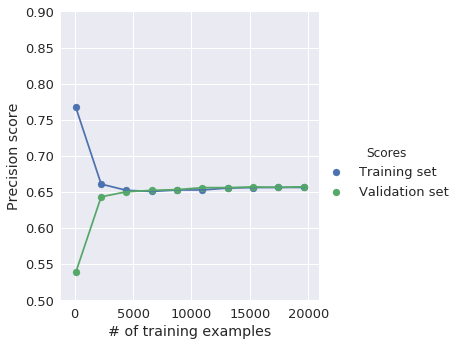

In [20]:
# Initialize a FacetGrid object using the table of scores and facet on
# the type of score
fig = sns.FacetGrid(
    make_tidy(sample_space, train_scores, valid_scores), hue='Scores', size=5
)

# Plot the learning curves, add a legend, and rescale y-axis
fig.map(plt.scatter, '# of training examples', 'Precision score')
fig.map(plt.plot, '# of training examples', 'Precision score') \
    .add_legend() \
    .set(ylim=(0.5, 0.9));

The learning curves indicate the model is not suffering from high variance and therefore, not overfitting.

<a id="cell8"></a>
## 8. Using nested cross-validation to optimize hyperparameters

We're now ready to optimize the regularization hyperparameter of the model. To do so without optimistically biasing the model and leaking information about the test set into the training set, let's incorporate nested cross-validation.

In [21]:
# Select a range of values to test the regularization hyperparameter
param_grid = [{'C': np.logspace(-3, 3, 10)}]

# Inner cross-validation loop to tune the hyperparameter (grid search model)
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

# Outer cross-validation loop to assess model performance
scores = cross_val_score(
    estimator=grid_search,
    X=X_std,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision'
)

# Display cross-validation scores
scores

array([ 0.65122378,  0.65307892,  0.65318417,  0.65661642,  0.64560205,
        0.65931156,  0.65470085,  0.65605659,  0.6483899 ,  0.68601583])

The precision scores across the different cross-validation folds doesn't very much&mdash;this is a sign that the model is stable. Let's finish up by computing the average precision score and its standard deviation.

In [22]:
# Display the average precision score
print('Precision: {} +/- {}'.format(scores.mean(), scores.std()))

Precision: 0.6564180070356752 +/- 0.010571400402487845


<a id="cell9"></a>
## 9. Top predictors of funded projects

To determine the features that were most predictive of funded projects, let's first identify the optimal regularization hyperparameter as identified by nested cross-validation. Since nested cross-validation doesn't actually train any functional models, we have to re-train the cross-validated grid search model and examine the optimal hyperparameter.

In [23]:
# Train a grid search model to identify the optimal hyperparameter
grid_search.fit(X_std, y_enc)

# Display the optimal hyperparameter
grid_search.best_params_

{'C': 0.0046415888336127772}

Let's use this hyperparameter value and train a final model on the entire training set to reduce pessimistic bias.

In [35]:
# Train the classifier on the entire dataset using the optimal hyperparameter
final_clf = LogisticRegression(C=grid_search.best_params_['C'])
final_clf.fit(X_std, y_enc);

While we're here, let's save the classifier and scaler used earlier.

In [36]:
# Serialize the classifier and the scaler objects
#joblib.dump(final_clf, 'trained_classifier.pkl')
#joblib.dump(scaler, 'trained_scaler.pkl')

Finally, let's examine the features that were most predictive of funded projects.

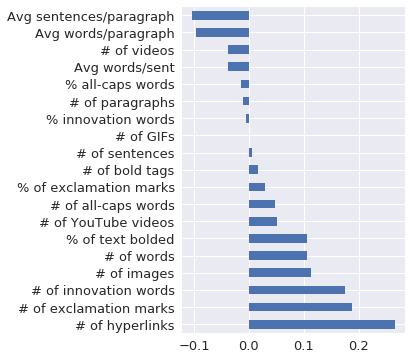

In [55]:
# Add the corresponding feature names to the parameters
feature_ranks = pd.DataFrame(final_clf.coef_, index=['parameter value'])
feature_ranks.columns = X_cleaned.columns

# Sort the feature weights
feature_ranks = feature_ranks.sort_values(
    'parameter value',
    axis=1,
    ascending=False
).T

# Display a plot of the feature weights
feature_ranks.plot(kind='barh', legend=False, figsize=(4, 6));
labels = [
    'Avg sentences/paragraph',
    'Avg words/paragraph',
    '# of videos',
    'Avg words/sent',
    '% all-caps words',
    '# of paragraphs',
    '% innovation words',
    '# of GIFs',
    '# of sentences',
    '# of bold tags',
    '% of exclamation marks',
    '# of all-caps words',
    '# of YouTube videos',
    '% of text bolded',
    '# of words',
    '# of images',
    '# of innovation words',
    '# of exclamation marks',
    '# of hyperlinks'
]
plt.yticks(np.arange(19), labels[::-1]);

Curiously, the number of hyperlinks is the top predictor. Since many of the successful projects were covered by the news media and the hyperlinks to those articles were included in the campaign, this makes sense. Even more intriguing is that my hypothesis about having innovation words was correct!

The other top predictors are more or less expected such as having more bolded text, exclamation marks, and images&mdash;they all draw serve to draw the reader's attention. 

One of the top predictors of *unfunded* projects was having higher average number of sentences per paragraph and words per paragraph. This indicates being succinct and breaking up long walls of text with sections is a major factor to getting funded!

<a id="cell10"></a>
## 10. Testing Kickstarter pages

For fun, let's engineer features for a sample Kickstarter page, such as the [Pebble 2](https://www.kickstarter.com/projects/getpebble/pebble-2-time-2-and-core-an-entirely-new-3g-ultra), and insert the prepared feature vector and target variable into the trained model to see how it fares with a highly successful project.

In [38]:
# Select a hyperlink
hyperlink = 'https://www.kickstarter.com/projects/getpebble/pebble-2-time-2-and-core-an-entirely-new-3g-ultra'

In [39]:
# Computed feature vector and standardize the values with the scaler used in
# the training set
computed_features = feature_engineering.process_project(hyperlink)
scaled_features = scaler.transform([computed_features])

# Perform the prediction
final_clf.predict(scaled_features)

array([1])

Great, the model works! We can even examine the probability of success.

In [40]:
# Display the probability of being funded with the given features
final_clf.predict_proba(scaled_features)[0, 1]

0.97188673999144715